# Description

We decided we will be working with the version of the data from NI2019 that Cesar has at BCBL. We will start our analysis with the multi-echo data in MNI space that has already undergone MEICA denoising (e.g., pc08 files).

#### 1. The first I did was to make sure that all pc08 files (all subjects, all echoes, all runs) are in the same grid

```bash
cd /data/SFIMJGC/PRJ_ME-ETS/BCBL2024/prcs_data/
3dinfo -same_all_grid ./P3SBJ??/D02_Preprocessed/pc08.P3SBJ??_Events0?_MEICA.E0?.spc.nii.gz
```

This returned all 1s (so yes, all in same grid)

***

#### 2. Download the Schaefer Atlas 400ROI/7NW from Thomas Yeo's github into the atlas folder, and then bring it into the pc08 grid

```bash
cd ${ATLAS_DIR}
3drefit -space MNI Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

@MakeLabelTable -lab_file Schaefer2018_400Parcels_7Network_order.txt 1 0 \
                -labeltable Schaefer2018_400Parcels_7Network.niml.lt \
                -dset Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz 

3dresample -inset Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz \
           -master ../prcs_data/P3SBJ06/D02_Preprocessed/pc08.P3SBJ06_Events01_MEICA.E01.spc.nii.gz \
           -rmode NN \
           -prefix Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.nii.gz

3drefit -labeltable Schaefer2018_400Parcels_7Networks.niml.lt Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.nii.gz
```
***

#### 3. Use 3dNetCorr to find the FOV common to all Sbjs/Runs/Echoes (according to 3dNetCorr)

```bash
sh /data/SFIMJGC/PRJ_ME-ETS/BCBL2024/code/me-ets/bash/check_atlas_vs_fov.sh
```

***

#### 4. Get a list with the ROIs that we need to remove from the altas in order to compute FC / edges with the same ROIs in all Sbj/Run/Echoes

In [1]:
import pandas as pd
from glob import glob
import os.path as osp
import subprocess
PRCS_DATA_DIR = '/data/SFIMJGC/PRJ_ME-ETS/BCBL2024/prcs_data/'
ATLAS_DIR='/data/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/'
ATLAS_NAME='Schaefer2018_400Parcels_7Networks'

In [2]:
roidat_files = glob(PRCS_DATA_DIR+'/*/*/rm.*_FOVcheck_000.roidat')
bad_roi_list = []
for roidata_path in roidat_files:
    roidata_file = osp.basename(roidata_path)
    sbj = (roidata_file.split('.')[1]).split('_')[0]
    run = (roidata_file.split('.')[1]).split('_')[1]
    echo = (roidata_file.split('.')[2]).split('_')[0]
    roidat_df = pd.read_csv(roidata_path,sep=' ', skipinitialspace=True, header=0)
    correct_columns = roidat_df.columns.drop(['#'])
    roidat_df = roidat_df.drop(['ROI_label'],axis=1)
    roidat_df.columns = correct_columns
    roidat_df = roidat_df.drop(['#.1'],axis=1)
    bad_rois = roidat_df[roidat_df['frac']<=0.1][['ROI','ROI_label']]
    print('++ INFO: %s/%s/%s --> Number of Bad Rois: %d' % (sbj,run,echo,bad_rois.shape[0]), end=' | ')
    for i,br in bad_rois.iterrows():
        bad_roi_list.append((br['ROI'],br['ROI_label']))

++ INFO: P3SBJ02/Events01/E02 --> Number of Bad Rois: 3 | ++ INFO: P3SBJ02/Events02/E02 --> Number of Bad Rois: 3 | ++ INFO: P3SBJ02/Events01/E01 --> Number of Bad Rois: 3 | ++ INFO: P3SBJ02/Events02/E03 --> Number of Bad Rois: 3 | ++ INFO: P3SBJ02/Events01/E03 --> Number of Bad Rois: 3 | ++ INFO: P3SBJ02/Events02/E01 --> Number of Bad Rois: 3 | ++ INFO: P3SBJ04/Events01/E02 --> Number of Bad Rois: 9 | ++ INFO: P3SBJ04/Events02/E03 --> Number of Bad Rois: 9 | ++ INFO: P3SBJ04/Events02/E01 --> Number of Bad Rois: 9 | ++ INFO: P3SBJ04/Events01/E01 --> Number of Bad Rois: 9 | ++ INFO: P3SBJ04/Events02/E02 --> Number of Bad Rois: 9 | ++ INFO: P3SBJ04/Events01/E03 --> Number of Bad Rois: 9 | ++ INFO: P3SBJ10/Events01/E02 --> Number of Bad Rois: 11 | ++ INFO: P3SBJ10/Events01/E03 --> Number of Bad Rois: 11 | ++ INFO: P3SBJ10/Events01/E01 --> Number of Bad Rois: 11 | ++ INFO: P3SBJ07/Events01/E02 --> Number of Bad Rois: 5 | ++ INFO: P3SBJ07/Events01/E03 --> Number of Bad Rois: 5 | ++ INFO: P3

In [3]:
bad_roi_list = list(set(bad_roi_list))

In [4]:
print(bad_roi_list)

[(114, '7Networks_LH_Limbic_OFC_1'), (116, '7Networks_LH_Limbic_OFC_3'), (117, '7Networks_LH_Limbic_OFC_4'), (151, '7Networks_LH_Default_Temp_3'), (115, '7Networks_LH_Limbic_OFC_2'), (325, '7Networks_RH_Limbic_TempPole_1'), (319, '7Networks_RH_Limbic_OFC_1'), (120, '7Networks_LH_Limbic_TempPole_2'), (323, '7Networks_RH_Limbic_OFC_5'), (338, '7Networks_RH_Cont_Temp_1'), (330, '7Networks_RH_Limbic_TempPole_6'), (122, '7Networks_LH_Limbic_TempPole_4'), (326, '7Networks_RH_Limbic_TempPole_2'), (321, '7Networks_RH_Limbic_OFC_3')]


In [5]:
print('++ INFO: Number of ROIs to remove = %d ROIs' % len(bad_roi_list))

++ INFO: Number of ROIs to remove = 14 ROIs


***

#### 5. Remove regions with bad coverage from atlas

In [6]:
bad_rois_minus = '-'.join([str(r)+'*equals(a,'+str(r)+')' for r,rs in bad_roi_list])
bad_rois_plus  = '+'.join([str(r)+'*equals(a,'+str(r)+')' for r,rs in bad_roi_list])
print(bad_rois_minus)
print(bad_rois_plus)

114*equals(a,114)-116*equals(a,116)-117*equals(a,117)-151*equals(a,151)-115*equals(a,115)-325*equals(a,325)-319*equals(a,319)-120*equals(a,120)-323*equals(a,323)-338*equals(a,338)-330*equals(a,330)-122*equals(a,122)-326*equals(a,326)-321*equals(a,321)
114*equals(a,114)+116*equals(a,116)+117*equals(a,117)+151*equals(a,151)+115*equals(a,115)+325*equals(a,325)+319*equals(a,319)+120*equals(a,120)+323*equals(a,323)+338*equals(a,338)+330*equals(a,330)+122*equals(a,122)+326*equals(a,326)+321*equals(a,321)


In [126]:
command=f"""module load afni; \
           cd {ATLAS_DIR}; \
           3dcalc -overwrite \
                  -a {ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.nii.gz \
                  -expr '{bad_rois_plus}' \
                  -prefix {ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.RemovedROIs.nii.gz; \
           3dcalc -overwrite \
                  -a      {ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.nii.gz \
                  -expr 'a-{bad_rois_minus}' \
                  -prefix rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz; \
           3drefit -labeltable {ATLAS_NAME}.niml.lt rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz"""
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-06-13

++ 3dcalc: AFNI version=AFNI_24.1.17 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.RemovedROIs.nii.gz
++ 3dcalc: AFNI version=AFNI_24.1.17 (Jun  6 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz
++ 3drefit: AFNI version=AFNI_24.1.17 (Jun  6 2024) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz
 + setting labeltable
 + loading and re-writing dataset rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz (/gpfs/gsfs12/users/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz

In [7]:
from nilearn.plotting import plot_roi

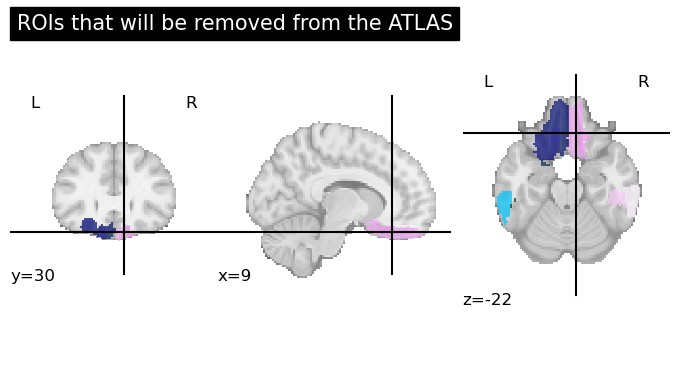

In [8]:
plot_roi(osp.join(ATLAS_DIR,f'{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.RemovedROIs.nii.gz'),title='ROIs that will be removed from the ATLAS')

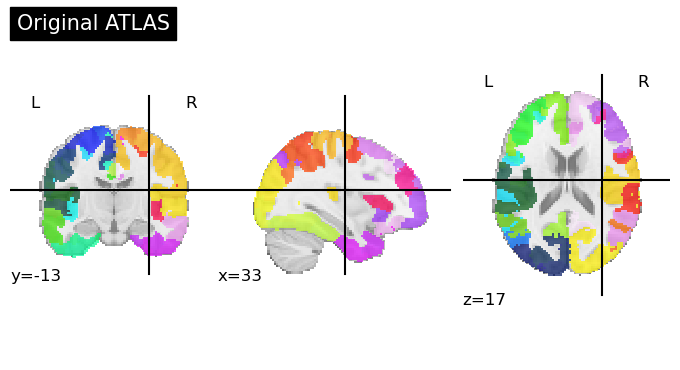

In [9]:
plot_roi(osp.join(ATLAS_DIR,f'{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.nii.gz'),title='Original ATLAS')

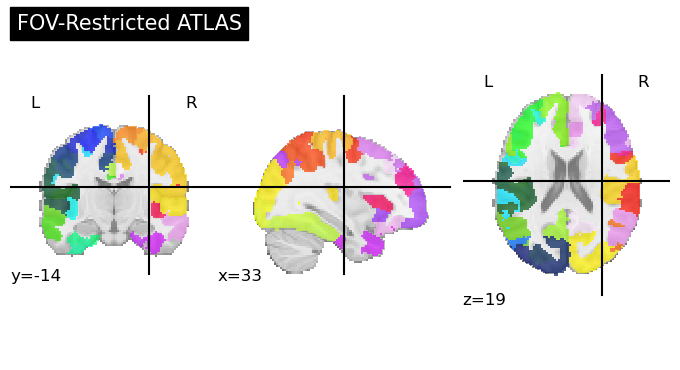

In [10]:
plot_roi(osp.join(ATLAS_DIR,f'rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz'),title='FOV-Restricted ATLAS')

***
#### 6. Rank the FOV-restricted Atlas

In [127]:
command = f"""module load afni; \
             cd {ATLAS_DIR}; \
             3dRank -prefix rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz -input rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz;"""
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-06-13

++ Output dataset /gpfs/gsfs12/users/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz


***
#### 7. Create rank corrected Order & Centroid Files

In [11]:
from sfim_lib.atlases.raking import correct_ranked_atlas

In [12]:
path_to_order_file     = osp.join(ATLAS_DIR,f'{ATLAS_NAME}_order.txt')
path_to_rank_file      = osp.join(ATLAS_DIR,f'rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz.rankmap.1D')
path_to_centroids_file = osp.join(ATLAS_DIR,f'{ATLAS_NAME}_order_FSLMNI152_2mm.Centroid_RAS.csv')
correct_ranked_atlas(path_to_order_file,path_to_centroids_file,path_to_rank_file)

++ INFO [correct_ranked_shaefer_atlas] Original Order File in memory [(400, 5)]
++ INFO [correct_ranked_shaefer_atlas] Original Centroids File in memory [(400, 4)]
++ INFO [correct_ranked_shaefer_atlas] Rank information in memory    [(387, 2)]
++ INFO [correct_ranked_shaefer_atlas] New order file written to disk: /data/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/Schaefer2018_400Parcels_7Networks_order.ranked.txt
++ INFO [correct_ranked_shaefer_atlas] New centroids file written to disk: /data/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/Schaefer2018_400Parcels_7Networks.Centroid_RAS.ranked.csv
 + Original Number of ROIs = 400
 + New      Number of ROIs = 386
 + Last entry in original Order File:
ID      7Networks_RH_Default_pCunPCC_9
R                                  208
G                                   64
B                                   77
Size                                 0
Name: 400, dtype: object
 + Last entry in new Orde

***
#### 8. Add corrected label table to the ranked version of the atlas

In [18]:
command = f"""module load afni; \
             cd {ATLAS_DIR}; \
             @MakeLabelTable -lab_file {ATLAS_NAME}_order.ranked.txt 1 0 -labeltable {ATLAS_NAME}_order.ranked.niml.lt -dset rm.{ATLAS_NAME}_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz;"""
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-06-13

++ 3drefit: AFNI version=AFNI_24.1.17 (Jun  6 2024) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz
 + setting labeltable
 + loading and re-writing dataset rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz (/gpfs/gsfs12/users/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets


***
#### 9. Create a Dataframe with all the necessary info about the final FOV-restricted Atlas

In [21]:
def rgb2hex(r,g,b):
    """
    Converts between two different versions of RGB color codes. Input as three separate integers between 0 and 256.
    Output will be in hexadecimal code.
    """
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [24]:
# Load the cetroid file for the ranked atlas in memory
centroids_info               = pd.read_csv(osp.join(ATLAS_DIR,f'{ATLAS_NAME}.Centroid_RAS.ranked.csv' ))
centroids_info['ROI Name']   = [label.split('7Networks_')[1] for label in centroids_info['ROI Name']]
centroids_info['Hemisphere'] = [item.split('_')[0] for item in centroids_info['ROI Name']]
centroids_info['Network']    = [item.split('_')[1] for item in centroids_info['ROI Name']]
# Load the color info file for the ranked atlas in memory
color_info = pd.read_csv(osp.join(ATLAS_DIR, f'{ATLAS_NAME}_order.ranked.txt'),sep='\t', header=None)
# Combine all the useful columns into a single new dataframe
df         = pd.concat([centroids_info[['ROI Label','Hemisphere','Network','ROI Name','R','A','S']],color_info[[2,3,4]]], axis=1)
df.columns = ['ROI_ID','Hemisphere','Network','ROI_Name','pos_R','pos_A','pos_S','color_R','color_G','color_B']
df['RGB']  = [rgb2hex(r,g,b) for r,g,b in df.set_index('ROI_ID')[['color_R','color_G','color_B']].values]
# Save the new data frame to disk
df.to_csv(osp.join(ATLAS_DIR,f'{ATLAS_NAME}.roi_info.csv'), index=False)

In [25]:
df.head(5)

,ROI_ID,Hemisphere,Network,ROI_Name,pos_R,pos_A,pos_S,color_R,color_G,color_B,RGB
0,1,LH,Vis,LH_Vis_1,-32,-42,-20,120,17,128,#781180
1,2,LH,Vis,LH_Vis_2,-30,-32,-18,120,17,129,#781181
2,3,LH,Vis,LH_Vis_3,-36,-62,-16,120,17,130,#781182
3,4,LH,Vis,LH_Vis_4,-24,-54,-8,120,17,131,#781183
4,5,LH,Vis,LH_Vis_5,-24,-72,-10,120,17,132,#781184


***
#### 10. Clean-up atlas directory

```bash
cd /data/SFIMJGC/PRJ_ME-ETS/BCBL2024/atlases/Schaefer2018_400Parcels_7Networks/

mkdir orig
mv Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv orig
mv Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz orig
mv Schaefer2018_400Parcels_7Networks_order.lut orig
mv Schaefer2018_400Parcels_7Networks_order.txt orig
mv Schaefer2018_400Parcels_7Networks.niml.lt orig

mkdir pc08grid
mv Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.nii.gz pc08grid
mv Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.RemovedROIs.nii.gz pc08grid
mv rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.nii.gz pc08grid

mv rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz Schaefer2018_400Parcels_7Networks.nii.gz
mv Schaefer2018_400Parcels_7Networks_order.ranked.niml.lt Schaefer2018_400Parcels_7Networks.niml.lt
mv Schaefer2018_400Parcels_7Networks.Centroid_RAS.ranked.csv Schaefer2018_400Parcels_7Networks.csv
mv Schaefer2018_400Parcels_7Networks_order.ranked.txt Schaefer2018_400Parcels_7Networks_order.txt
mv rm.Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.pc08grid.fov_restricted.ranked.nii.gz.rankmap.1D Schaefer2018_400Parcels_7Networks.rankmap.1D
```